In [1]:
# Library
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords

In [2]:
# Baca dataset
df = pd.read_csv('data/Tempat-Wisata-Toba-Preprocessing.csv')

# Bersihkan data
df = df.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1, errors='ignore')
df.dropna(inplace=True) 

In [3]:
df.head() 

,address,PlaceID,Nama_tempat_wisata,Category,ReviewerId,Rating,Reviews
1,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",0,PASIR PUTIH LUMBAN BULBUL,Wisata Bahari,1.119090e+20,5.0,bagus
3,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",0,PASIR PUTIH LUMBAN BULBUL,Wisata Bahari,1.130720e+20,5.0,sangat menyenagkan
4,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",0,PASIR PUTIH LUMBAN BULBUL,Wisata Bahari,1.061730e+20,5.0,bebas foto dimana aja cuma 2k
6,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",0,PASIR PUTIH LUMBAN BULBUL,Wisata Bahari,1.142390e+20,5.0,amazing pengen kesini lagi
8,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",0,PASIR PUTIH LUMBAN BULBUL,Wisata Bahari,1.047430e+20,3.0,jalan menuju lokasi perlu diperhatikan oleh pe...


In [4]:
# Split data menjadi train, validation, dan test  dengan proporsi 70:15:15
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# print data
print('Train shape: ', train_df.shape)
print('Validation shape: ', val_df.shape)
print('Test shape: ', test_df.shape)


Train shape:  (15516, 7)
Validation shape:  (3325, 7)
Test shape:  (3325, 7)


In [5]:
# Fungsi untuk membuat fitur item
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
def create_item_features(df):
    # Agregasi fitur teks
    text_features = df.groupby('PlaceID').agg({
        'Reviews': ' '.join,
        'Category': 'first', 
        'Rating': 'mean'
    }).reset_index()
    
    # TF-IDF untuk reviews
    factory = StopWordRemoverFactory()
    stopword = factory.create_stop_word_remover()
    text_features['Reviews'] = text_features['Reviews'].apply(stopword.remove)
    tfidf = TfidfVectorizer(
        stop_words=stopwords.words('indonesian'),
        max_features=50
    )
    reviews_tfidf = tfidf.fit_transform(text_features['Reviews'])
    
    # Normalisasi rating
    normalized_ratings = (text_features['Rating'] - text_features['Rating'].min()) / (text_features['Rating'].max() - text_features['Rating'].min())
    
    # Similarity matrix untuk reviews
    reviews_similarity = cosine_similarity(reviews_tfidf)
    
    # Similarity matrix untuk ratings
    ratings_similarity = cosine_similarity(normalized_ratings.values.reshape(-1, 1))

    alpha = 0.7  
    beta = 0.3   
    
    combined_similarity = alpha * reviews_similarity + beta * ratings_similarity
    
    return combined_similarity, text_features


In [6]:
# Buat similarity matrix
sim_matrix, item_features = create_item_features(train_df)

print(sim_matrix)  

c:\Users\estop\OneDrive\Dokumen\Sem 7\Sisrek\Proyek-SISREK_12\proyeksysrek\Lib\site-packages\sklearn\feature_extraction\text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'sekurang', 'setidak', 'tama', 'tidaknya'] not in stop_words.
  warnings.warn(


[[1.         0.56829754 0.53890456 ... 0.51864473 0.78464584 0.65198373]
 [0.56829754 1.         0.53004298 ... 0.62024539 0.76772996 0.79657085]
 [0.53890456 0.53004298 1.         ... 0.42515586 0.64700261 0.60836713]
 ...
 [0.51864473 0.62024539 0.42515586 ... 1.         0.69398165 0.6585137 ]
 [0.78464584 0.76772996 0.64700261 ... 0.69398165 1.         0.90615286]
 [0.65198373 0.79657085 0.60836713 ... 0.6585137  0.90615286 1.        ]]


In [7]:
# Kelas model Item-Based KNN
class ItemBasedKNN:
    def __init__(self, similarity_matrix, item_features):
        self.similarity_matrix = similarity_matrix
        self.item_features = item_features
        
    def get_recommendations(self, place_id, k=5):
        try:
            idx = self.item_features[self.item_features['PlaceID'] == place_id].index[0]
            sim_scores = list(enumerate(self.similarity_matrix[idx]))
            sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
            sim_scores = sim_scores[1:k+1]
            place_indices = [i[0] for i in sim_scores]
            return self.item_features.iloc[place_indices]['PlaceID'].tolist()
        except IndexError:
            return []

    def predict_rating(self, user_id, place_id, k=5):
        user_ratings = train_df[train_df['ReviewerId'] == user_id]
        if user_ratings.empty:
            return None

        try:
            idx = self.item_features[self.item_features['PlaceID'] == place_id].index[0]
            sim_scores = self.similarity_matrix[idx]

            weighted_sum = 0
            sim_sum = 0

            for _, row in user_ratings.iterrows():
                item_idx = self.item_features[self.item_features['PlaceID'] == row['PlaceID']].index[0]
                sim = sim_scores[item_idx]
                weighted_sum += sim * row['Rating']
                sim_sum += abs(sim)

            if sim_sum == 0:
                return None

            return weighted_sum / sim_sum
        except IndexError:
            return None

In [8]:
# Inisialisasi model
knn_model = ItemBasedKNN(sim_matrix, item_features)

In [9]:
# find best k
def find_best_k(model, val_data, k_values):
    best_k = 0
    best_rmse = float('inf')

    for k in k_values:
        actual_ratings = []
        predicted_ratings = []

        for _, row in val_data.iterrows():
            pred_rating = model.predict_rating(row['ReviewerId'], row['PlaceID'], k)
            if pred_rating is not None:
                actual_ratings.append(row['Rating'])
                predicted_ratings.append(pred_rating)

        if actual_ratings and predicted_ratings:
            rmse = np.sqrt(mean_squared_error(actual_ratings, predicted_ratings))
            print(f"k={k}, RMSE={rmse}")

            if rmse < best_rmse:
                best_rmse = rmse
                best_k = k

    print(f"Nilai k terbaik berdasarkan validasi: {best_k}, RMSE: {best_rmse}")
    return best_k

In [10]:
# validasi model untuk mencari nilai k terbaik
k_values=range(1, 20)
best_k = find_best_k(knn_model, val_df, k_values)

k=1, RMSE=0.9672462178625733
k=2, RMSE=0.9672462178625733
k=3, RMSE=0.9672462178625733
k=4, RMSE=0.9672462178625733
k=5, RMSE=0.9672462178625733
k=6, RMSE=0.9672462178625733
k=7, RMSE=0.9672462178625733
k=8, RMSE=0.9672462178625733
k=9, RMSE=0.9672462178625733
k=10, RMSE=0.9672462178625733
k=11, RMSE=0.9672462178625733
k=12, RMSE=0.9672462178625733
k=13, RMSE=0.9672462178625733
k=14, RMSE=0.9672462178625733
k=15, RMSE=0.9672462178625733
k=16, RMSE=0.9672462178625733
k=17, RMSE=0.9672462178625733
k=18, RMSE=0.9672462178625733
k=19, RMSE=0.9672462178625733
Nilai k terbaik berdasarkan validasi: 1, RMSE: 0.9672462178625733


In [11]:
# Fungsi untuk menghitung metrik ranking
def calculate_ranking_metrics(actual, predicted, k):
    precision = len(set(actual) & set(predicted[:k])) / k if k > 0 else 0
    recall = len(set(actual) & set(predicted[:k])) / len(actual) if len(actual) > 0 else 0
    
    # Calculate MAP@K
    ap = 0
    hits = 0
    for i, p in enumerate(predicted[:k]):
        if p in actual:
            hits += 1
            ap += hits / (i + 1)
    map_k = ap / min(len(actual), k) if k > 0 else 0
    
    return precision, recall, map_k


In [12]:
# Evaluasi model
def evaluate_model(model, test_data, k_best):
    actual_ratings = []
    predicted_ratings = []
    ranking_metrics = {'precision': [], 'recall': [], 'map': []}
    
    for user_id in test_data['ReviewerId'].unique():
        user_ratings = test_data[test_data['ReviewerId'] == user_id]

        # Rating-based metrics
        for _, row in user_ratings.iterrows():
            pred_rating = model.predict_rating(user_id, row['PlaceID'], k=k_best)
            if pred_rating is not None:
                actual_ratings.append(row['Rating'])
                predicted_ratings.append(pred_rating)

        # Ranking-based metrics
        actual_items = user_ratings['PlaceID'].tolist()
        if actual_items:
            recommended_items = model.get_recommendations(actual_items[0], k=k_best)

            # Calculate metrics for k-best recommendations
            p, r, m = calculate_ranking_metrics(actual_items, recommended_items, k_best)
            ranking_metrics['precision'].append(p)
            ranking_metrics['recall'].append(r)
            ranking_metrics['map'].append(m)

    # Calculate rating-based metrics
    rmse = np.sqrt(mean_squared_error(actual_ratings, predicted_ratings))
    mae = mean_absolute_error(actual_ratings, predicted_ratings)

    # Calculate average ranking metrics
    ranking_metrics = {k: np.mean(v) for k, v in ranking_metrics.items()}

    return rmse, mae, ranking_metrics

In [13]:
# Evaluasi dan visualisasi
rmse, mae, ranking_metrics = evaluate_model(knn_model, test_df, k_best=best_k)

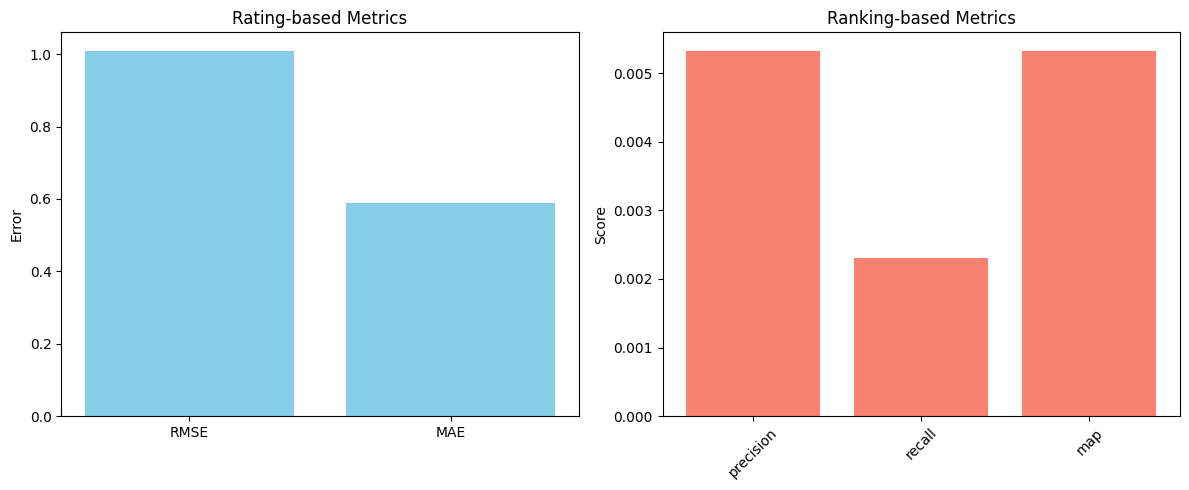

RMSE: 1.0099769276794763
MAE: 0.5898172276277835
Ranking Metrics:
precision: 0.005330490405117271
recall: 0.0023098791755508173
map: 0.005330490405117271


In [14]:

def plot_results(rmse, mae, ranking_metrics):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.bar(['RMSE', 'MAE'], [rmse, mae], color='skyblue')
    plt.title('Rating-based Metrics')
    plt.ylabel('Error')
    
    plt.subplot(1, 2, 2)
    metrics = list(ranking_metrics.keys())
    values = list(ranking_metrics.values())
    plt.bar(metrics, values, color='salmon')
    plt.title('Ranking-based Metrics')
    plt.ylabel('Score')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

plot_results(rmse, mae, ranking_metrics)

# Cetak hasil evaluasi
print('RMSE:', rmse)
print('MAE:', mae)
print('Ranking Metrics:')
for k, v in ranking_metrics.items():
    print(f'{k}: {v}')